# Testing of Fourier Transforms and the like

In [71]:
from typing import Tuple
import numpy as np
from scipy import constants as cnst

import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator


## Functions

In [72]:
COLUMN = lambda x : np.array(x).reshape(-1, 1)
ROW = lambda x : np.array(x).reshape(1, -1)

IND = lambda N : COLUMN(np.arange(N))
AXS = lambda N : IND(N)-np.floor(N/2)

T2F = lambda E : np.fft.ifft(np.fft.ifftshift(E, axes=0), axis=0)
F2T = lambda E : np.fft.fftshift(np.fft.fft(E, axis=0), axes=0)
F2TN = lambda E, N : np.fft.fftshift(np.fft.fft(E, N, axis=0), axes=0)

abs2 = lambda z : z**2 if np.isrealobj(z) else z.real**2 + z.imag**2
NORM = lambda A, ax : A / np.max(A, axis=ax)
NORMS = lambda A, ax : A / np.sum(A, axis=ax)
NORMI0 = lambda A, ax : A / np.sqrt(np.max(abs2(A), axis=ax))
NORMI = lambda A, ax : A / np.sqrt(np.sum(abs2(A), axis=ax))

Convert_wl = lambda x : 2e-6 * cnst.pi * cnst.c / x

def GenerateAxes(Nw:int, dw:float, Padding:int=None) -> Tuple[np.ndarray, np.ndarray, float, float]:
    n = AXS(Nw)
    w = n*dw

    if Padding is None:
        dt = 2*np.pi/(Nw*dw)
        t = n*dt
    else:
        Nt = Padding * Nw
        dt = 2*np.pi/(Nt*dw)
        t = AXS(Nt)*dt
    return (w, t, dt, dw)

def gauss1D(x:float, x0:float, FWHM:float, order:int=1) -> np.ndarray:
    x = x-x0
    x = 2*x/FWHM
    xn = x ** (2*np.abs(order))
    return np.exp(-np.log2(2)*xn)

## Fourier Transform & Shift Theorem
Just checking the Fourier transform and application of the shift theorem is correct.

Typically we define the spectral window to only just cover the pulse spectrum. Therefore the frequency axis does not start at DC, i.e. `w[0]!=0`, and the sampling rate is insufficient to observe the correct field oscillations. The first problem is addressed using the shift theorem, in which the temporal field is multiplied by the correct linear phase term. The second problem is addressed by padding the spectrum with zeros before Fourier transforming into the time domain.

In [73]:
# Pulse parameters
DW = .1
l0 = 800
w0 = Convert_wl(l0)

# Generate sampling axes
Nw = 1<<7       #   2^7
tPad = 1<<6     #   2^6
w, t, _, _ = GenerateAxes(Nw, DW/10, tPad)
w1 = w + w0
l = Convert_wl(w1)
dw0 = DW/2

# Generate spectrum
Iw = gauss1D(w, ROW([0, dw0]), DW)

# Linear temporal phase (shift-theorem for non-DC component)
SHIFT = np.exp(-1j*(w0+w[1])*t)

# Fourier transform with zero padding followed by application of shift theorem
At = F2TN(np.sqrt(Iw), tPad*Nw) * SHIFT

### Plot results

(-1.0, 11.0)

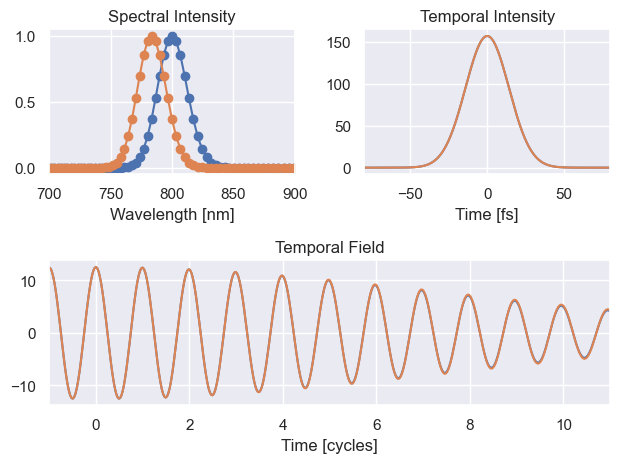

In [74]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.plot(l, Iw, "o-")
ax.set_xlim([700, 900])
ax.set_title("Spectral Intensity")
ax.set_xlabel("Wavelength [nm]")

ax = fig.add_subplot(gs[0,1])
ax.plot(t, abs2(At))
ax.set_xlim(COLUMN([-1, 1])*8*np.log2(2)/DW)
ax.set_title("Temporal Intensity")
ax.set_xlabel("Time [fs]")

ax = fig.add_subplot(gs[1,:])
ax.plot((w0+ROW([0, dw0]))*t/(2*np.pi), At.real)
ax.set_title("Temporal Field")
ax.set_xlabel("Time [cycles]")
ax.set_xlim([-1, 11])

# Sum-Frequency Generation
This is to test that the sum of two fields yields the correct solution.

Two spectra, centred at different central frequencies, and both containing two well-separated frequency components, are frequency mixed. The output should yield four frequency peaks.

In [94]:
# Pulse parameters
l01 = np.array([[700, 850], [800, 900]])
w01 = Convert_wl(l01)
w02 = COLUMN(w01[:, 0]) + ROW(w01[:, 1])
w01_av = np.mean(w01, axis=0)
l02 = Convert_wl(w02)

# Generate axes
Nw = 1<<8
DW = .05
w, t, _, _ = GenerateAxes(Nw, DW*30/Nw)
w1 = w + w01_av
w2 = w + np.sum(w01_av)
l1 = Convert_wl(w1)
l2 = Convert_wl(w2)

# Generate pulses
Iw1 = np.sum(gauss1D(w, (w01-w01_av).reshape(2, 1, 2), DW, 2), axis=0)

# SFG spectrum
# Shift-theorem: since the phases add together, one only needs to worry about the total difference
SHIFT = np.exp(1j*(w2[0]-sum(w1[0,:])) * t)
Et2 = COLUMN(np.prod(F2T(np.sqrt(Iw1)), axis=1)) * SHIFT
Iw2 = NORM(abs2(T2F(Et2)), None)

### Plot Results

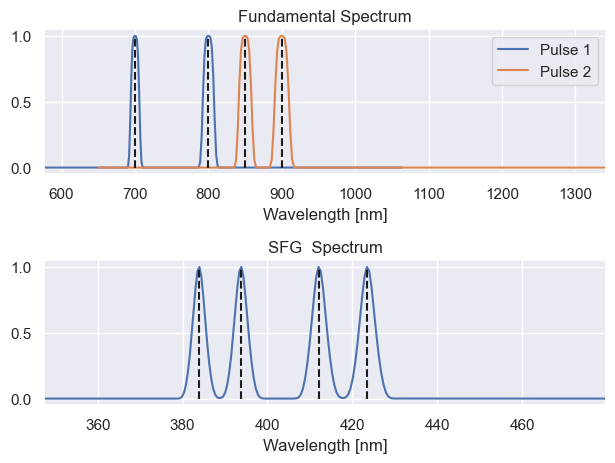

In [95]:
fig, ax = plt.subplots(2,1)

ax[0].plot(l1, Iw1)
ax[0].plot(np.tile(ROW(l01), [2, 1]), 
           COLUMN([0, 1])+0*ROW(l01), "k--")
ax[0].set_title("Fundamental Spectrum")
ax[0].set_xlabel("Wavelength [nm]")
ax[0].legend(("Pulse 1", "Pulse 2"))
ax[0].autoscale(axis="x", tight=True)

ax[1].plot(l2, Iw2)
ax[1].plot(np.tile(ROW(l02), [2, 1]), 
           COLUMN([0, 1])+0*ROW(l02), "k--")
ax[1].set_title("SFG  Spectrum")
ax[1].set_xlabel("Wavelength [nm]")
ax[1].autoscale(axis="x", tight=True)

fig.tight_layout()